In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import sys
import numpy as np
import plotly
import plotly.graph_objs as go
import pandas as pd
import math
import random
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
plotly.offline.init_notebook_mode(connected=False)
warnings.filterwarnings('ignore')
sns.set_style("whitegrid", {'grid.linestyle': '--'})

## functions

1. sin() 
> generate sine wave
1. toy_problem()  
> include noise to sine wave
1. make_dataset  
> generate dataset for learning of RNN

In [3]:
def sin(x, T=100):
    return np.sin(2.0*np.pi * x / T)

In [4]:
def toy_problem(T=100, ampl=0.05):
    x = np.arange(0, 2 * T + 1)
    noise = ampl * np.random.uniform(low=-1.0, high=1.0, size=len(x))
    return sin(x) + noise

In [5]:
def make_dataset(raw_data, n_prev=100, maxlen=25):
    data, target = [], []
    
    for i in range(len(raw_data) - maxlen):
        data.append(raw_data[i : i + maxlen])
        target.append(raw_data[i + maxlen])
        
    reshaped_data = np.array(data).reshape(len(data), maxlen, 1)
    reshaped_target = np.array(target).reshape(len(target), 1)
    
    return reshaped_data, reshaped_target

### Generate Noise sin Wave

ノイズ入りサイン波の生成

In [6]:
function = toy_problem(T=100)

##### Data Shaping for LSTM
LSTM用にデータ整形

In [7]:
data, label = make_dataset(function, maxlen=25)
print(data.shape)

(176, 25, 1)


* length_of_sequence : LSTMの入力の長さ
* in_out_neurons : 時系列データの単位時間における特徴量の次元数 (今回は単位時間あたり1つのスカラー量なので 1)
* n_hidden : 隠れ層の次元数

In [8]:
length_of_sequence = data.shape[1]
in_out_neurons = 1
n_hidden = 300

##  Model Definision

In [9]:
model = Sequential()
model.add(LSTM(n_hidden, batch_input_shape=(None, length_of_sequence, in_out_neurons), return_sequences=False))
model.add(Dense(in_out_neurons))
model.add(Activation('linear'))
optimizer = Adam(lr=1e-3)
model.compile(loss="mean_squared_error", optimizer=optimizer)

## Learning

In [10]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=5)

In [11]:
model.fit(data, label,
         batch_size=100, epochs=200,
         validation_split=0.1, callbacks=[early_stopping]
         )

Epoch 1/200
2/2 [==============================] - 1s 396ms/step - loss: 0.4466 - val_loss: 0.0400
Epoch 2/200
2/2 [==============================] - 0s 83ms/step - loss: 0.1514 - val_loss: 0.2765
Epoch 3/200
2/2 [==============================] - 0s 88ms/step - loss: 0.1134 - val_loss: 0.0928
Epoch 4/200
2/2 [==============================] - 0s 127ms/step - loss: 0.0447 - val_loss: 0.0160
Epoch 5/200
2/2 [==============================] - 0s 84ms/step - loss: 0.0415 - val_loss: 0.0137
Epoch 6/200
2/2 [==============================] - 0s 101ms/step - loss: 0.0401 - val_loss: 0.0101
Epoch 7/200
2/2 [==============================] - 0s 92ms/step - loss: 0.0202 - val_loss: 0.0113
Epoch 8/200
2/2 [==============================] - 0s 76ms/step - loss: 0.0113 - val_loss: 0.0213
Epoch 9/200
2/2 [==============================] - 0s 77ms/step - loss: 0.0099 - val_loss: 0.0092
Epoch 10/200
2/2 [==============================] - 0s 93ms/step - loss: 0.0038 - val_loss: 0.0017
Epoch 11/200
2/2

## Prediction | Training data

In [12]:
predicted = model.predict(data)

## Prediction | Future data 

In [13]:
future_test = data[-1].T
time_length = future_test.shape[1]
future_result = np.empty((0))

In [14]:
for step in range(400):
    test_data= np.reshape(future_test, (1, time_length, 1))
    batch_predict = model.predict(test_data)
    
    future_test = np.delete(future_test, 0)
    future_test = np.append(future_test, batch_predict)
    
    future_result = np.append(future_result, batch_predict)

## Plot with Seaborn 

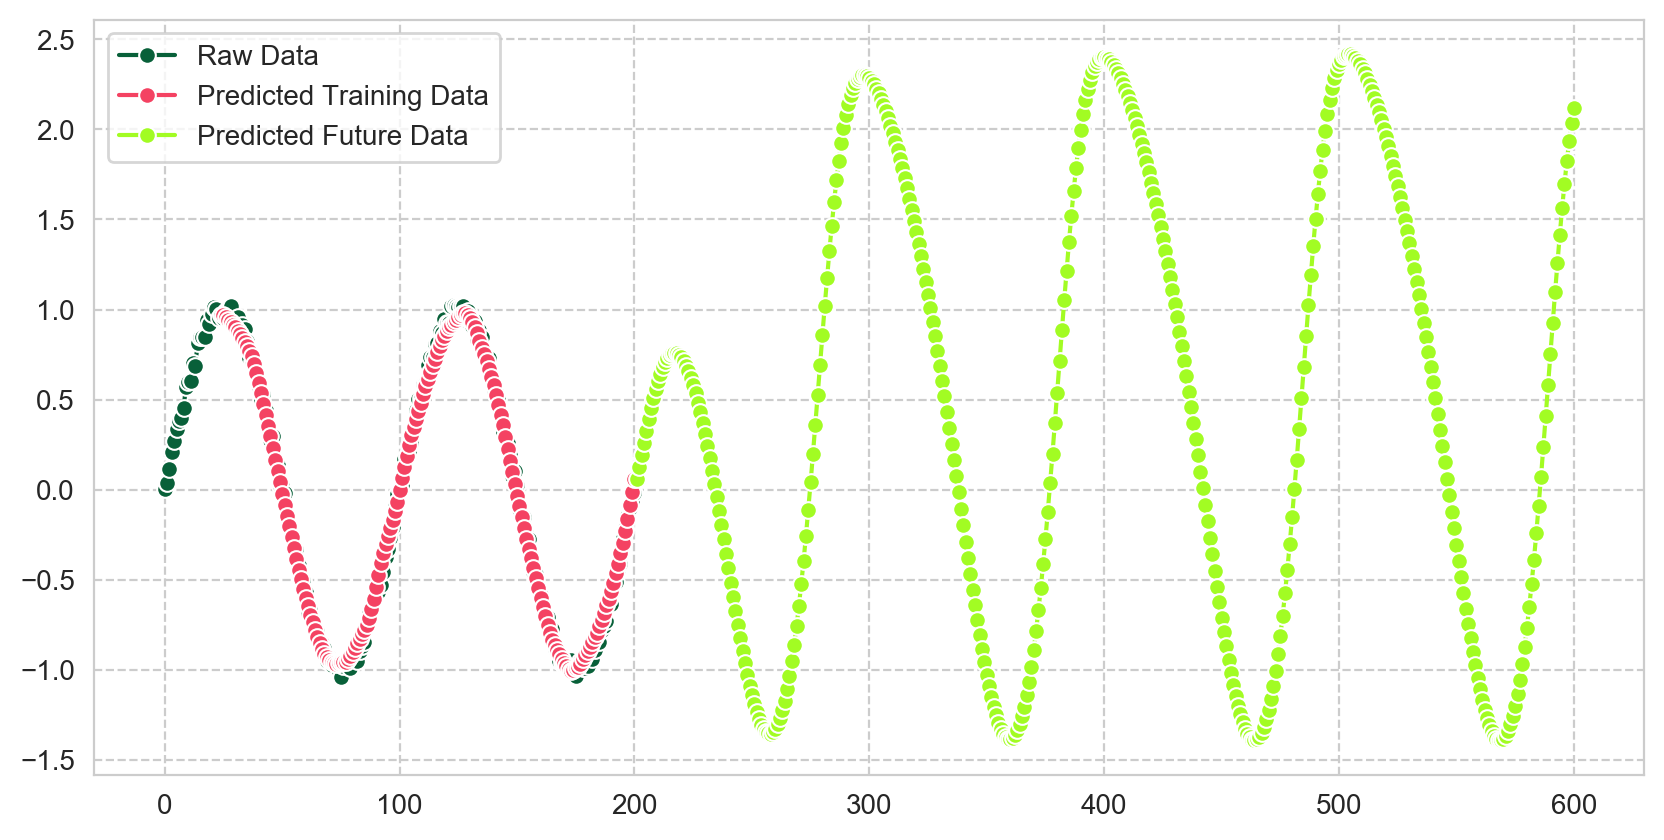

In [15]:
fig = plt.figure(figsize=(10,5),dpi=200)
sns.lineplot(
    color="#086039",
    data=function,
    label="Raw Data",
    marker="o"
)

sns.lineplot(
    color="#f44262",
    x=np.arange(25, len(predicted)+25),
    y=predicted.reshape(-1),
    label="Predicted Training Data",
    marker="o"
)

sns.lineplot(
    color="#a2fc23",
    y= future_result.reshape(-1),
    x = np.arange(0+len(function), len(future_result)+len(function)),
    label="Predicted Future Data",
    marker="o"
)

##  Plot with Plotly

In [16]:
data_raw = go.Scatter(
    y = function, 
    x  = np.arange(0, len(function)),
    name = 'Raw Data',
    mode = 'lines',
    line = dict(
        color = 'red'
    )
)

predicted_graph = go.Scatter(
    y = predicted.reshape(-1),
    x = np.arange(25, len(predicted)+25),
    name  = 'Predicted Training Data',
    mode = 'lines',
    line = dict(
        color = 'blue'
    )
)

predicted_future = go.Scatter(
    y = future_result.reshape(-1),
    x = np.arange(0+len(function), len(future_result)+len(function)),
    name = 'Predicted Future Data',
    mode = 'lines',
    line = dict(
        color = 'green'
    )
)

data = [data_raw, predicted_graph, predicted_future]
plotly.offline.iplot(data)

## Expand length of samples

サンプルの長さを長くしてみる

### Generate Noise sin Wave

ノイズ入りサイン波の生成

In [17]:
ex_function = toy_problem(T=300)

##### Data Shaping for LSTM
LSTM用にデータ整形

In [18]:
ex_data, ex_label = make_dataset(ex_function, maxlen=50)
print(ex_data.shape)

(551, 50, 1)


* ex_length_of_sequence : LSTMの入力の長さ
* ex_in_out_neurons : 時系列データの単位時間における特徴量の次元数 (今回は単位時間あたり1つのスカラー量なので 1)
* ex_n_hidden : 隠れ層の次元数

In [19]:
ex_length_of_sequence  = ex_data.shape[1]
ex_in_out_neurons = 1
ex_n_hidden = 300

##  Model Definision

In [20]:
ex_model = Sequential()
ex_model.add(LSTM(ex_n_hidden, batch_input_shape=(None, ex_length_of_sequence, ex_in_out_neurons), return_sequences=False))
ex_model.add(Dense(ex_in_out_neurons))
ex_model.add(Activation('linear'))
ex_optimizer = Adam(lr=1e-3)
ex_model.compile(loss="mean_squared_error", optimizer=ex_optimizer)

## Learning

In [21]:
ex_early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=5)

In [22]:
ex_model.fit(
    ex_data, ex_label,
    batch_size=100, epochs=200,
    validation_split=0.1, callbacks=[ex_early_stopping]
)

Epoch 1/200
5/5 [==============================] - 2s 359ms/step - loss: 0.2357 - val_loss: 0.0626
Epoch 2/200
5/5 [==============================] - 1s 265ms/step - loss: 0.0379 - val_loss: 0.0120
Epoch 3/200
5/5 [==============================] - 1s 289ms/step - loss: 0.0095 - val_loss: 0.0075
Epoch 4/200
5/5 [==============================] - 1s 245ms/step - loss: 0.0089 - val_loss: 0.0022
Epoch 5/200
5/5 [==============================] - 1s 267ms/step - loss: 0.0039 - val_loss: 0.0029
Epoch 6/200
5/5 [==============================] - 1s 288ms/step - loss: 0.0036 - val_loss: 0.0043
Epoch 7/200
5/5 [==============================] - 2s 302ms/step - loss: 0.0028 - val_loss: 0.0033
Epoch 8/200
5/5 [==============================] - 2s 314ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 9/200
5/5 [==============================] - 2s 302ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 10/200
5/5 [==============================] - 1s 285ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 11/

## Prediction | Training data

In [23]:
ex_predicted = ex_model.predict(ex_data)

## Prediction | Future data

In [24]:
ex_future_test = ex_data[-1].T
ex_time_length = ex_future_test.shape[1]
ex_future_result = np.empty((0))

In [25]:
for step in  range(400):
    ex_test_data = np.reshape(ex_future_test, (1, ex_time_length, 1))
    ex_batch_predict = ex_model.predict(ex_test_data)
    
    ex_future_test = np.delete(ex_future_test, 0, axis=1)
    ex_future_test = np.append(ex_future_test, ex_batch_predict, axis=1)
    
    ex_future_result = np.append(ex_future_result, ex_batch_predict)

## Plot with Seaborn 

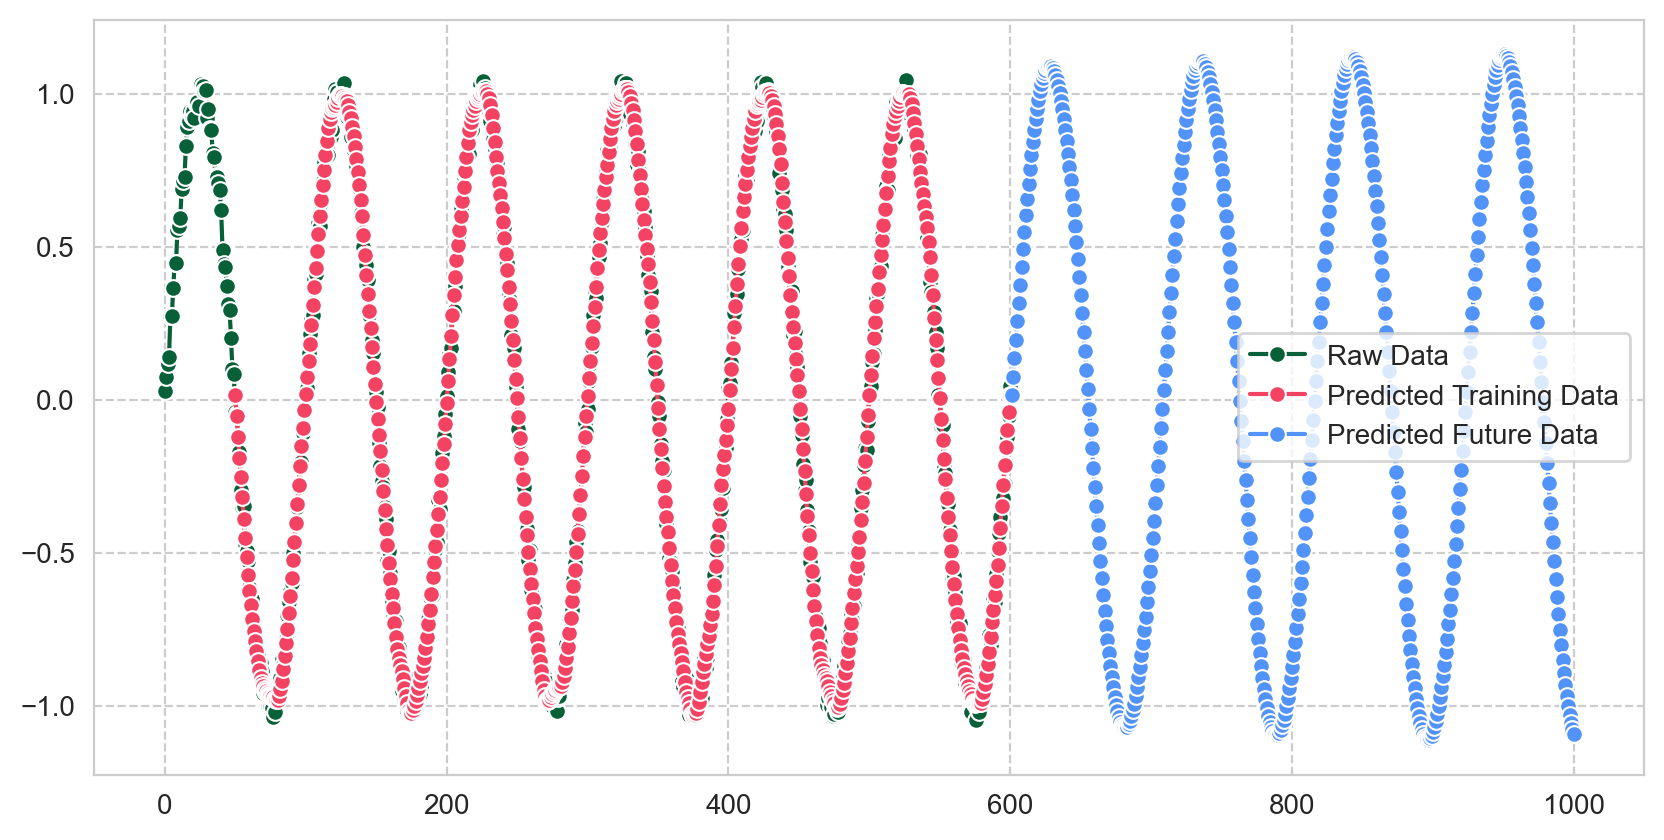

In [26]:
fig = plt.figure(figsize=(10, 5), dpi=200)
sns.lineplot(
    color="#086039",
    data=ex_function,
    label="Raw Data",
    marker="o"
)

sns.lineplot(
    color="#f44262",
    x=np.arange(50, len(ex_predicted)+50),
    y=ex_predicted.reshape(-1),
    label="Predicted Training Data",
    marker="o"
)

sns.lineplot(
    color="#5293fa",
    x= np.arange(0+len(ex_function), len(ex_future_result) + len(ex_function)),
    y = ex_future_result.reshape(-1),
    label="Predicted Future Data",
    marker="o"
)

## Plot with Plotly

In [27]:
data_raw = go.Scatter(
    x = np.arange(0, len(ex_function)),
    y = ex_function,
    name = 'Raw Data',
    mode = 'lines',
    line = dict(
        color = 'red'
    )
)

predicted_graph = go.Scatter(
    x = np.arange(50, len(ex_predicted)+25),
    y =  ex_predicted.reshape(-1),
    name = 'Predicted Training Data',
    line = dict(
    color='blue'
    )
)

predicted_future = go.Scatter(
    x = np.arange(0 + len(ex_function), len(ex_future_result)+len(ex_function)),
    y = ex_future_result.reshape(-1),
    name = 'Predicted Future Data',
    mode = 'lines',
    line = dict(
        color = 'green'
    )
)

data =  [data_raw, predicted_graph, predicted_future]
plotly.offline.iplot(data)